# Gaussian Process Emulation of the Deterministic BusSim Model

In this notebook we will explore the deterministic `BusSim` model from the DUST project and attempt to emulate some of the model outputs using Gaussian Processes.

The `BusSim` model code upon which this project is based is available on [GitHub](https://github.com/Urban-Analytics/dust/tree/main/Projects/ABM_DA/bussim), and the accompanying paper _Dealing with uncertainty in agent-based models for short-term predictions_, Kieu et al. (2019) is available on [arXiv](https://arxiv.org/abs/1908.08288).

This `BusSim` model was selected for this exploratory study of GP emulation because of its structure and complexity level.

## Aims

- Explore how the outputs of `BusSim` model are influenced by selected parameters
- Choose the outputs that we want to emulate using a GP
- Emulate model outputs as one parameter is varied
  - How well does the emulator perform? How do settings influence this?
  - How does the uncertainty estimate of the GP link to the bus movements in the model?
- Repeat the above investigation while varing two model parameters

## Background material

If new to Gaussian process emulation, the following resources may be useful.

### Introductory material
- [Gaussian process emulation](https://www.newton.ac.uk/seminar/20180111100011001/), Tony O'Hagan: Seminar from a workshop on uncertainty quantification
- [Machine learning - Introduction to Gaussian Processes](https://www.youtube.com/watch?v=4vGiHC35j9s&list=PLE6Wd9FR--EdyJ5lbFl8UuGjecvVw66F6&index=12), Nando de Freitas: Two lectures out of a longer lecture series on machine learning

### Further detail
- [A visual exploration of Gaussian Processes](https://distill.pub/2019/visual-exploration-gaussian-processes/), Görtler, et al. (2019): Blog post with some particularly intuitive interactive diagrams; useful for getting a feel for different kernels
- [Gaussian processes - From scratch](https://peterroelants.github.io/posts/gaussian-process-tutorial/), Peter Roelants: A three-part blog post on GPs, with extra detail on kernels in the later parts
- [Tutorial from the Multi-Output Gaussian Process Emulator (MOGP) package](https://mogp-emulator.readthedocs.io/en/latest/intro/tutorial.html#tutorial): Hands-on example of the use of GP emulators

### Books and papers
- [Bayesian Analysis of Computer Code Outputs: A tutorial](http://www.tonyohagan.co.uk/academic/pdf/BACCO-tutorial.pdf), Tony O'Hagan: Covers similar material to the first video
- [Introduction to Gaussian Processes](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.81.1927&rep=rep1&type=pdf), David MacKay: Much more mathematical detail than the blog posts linked above

We'll start by introducing the agent-based model that we will use for most of our investigations into the application of GPs.
The `BusSim` model simulates the movement of buses between regularly-spaced stops on a route.
At each stop, the buses will wait until passengers have alighted or departed before continuing to the next stop.

In [1]:
# Import the bus model, analysis/plotting libraries and GP library
from BusSim_deterministic import run_model
from IPython.display import HTML    # for animation
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import mogp_emulator

# Increase default figure size
plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["font.size"] = 16

## Set up the model

We'll run the model with a sensible set of default parameters, as used in previous studies of this model.

The two parameters that we will vary in this notebook, and investigate in more detail, are **traffic speed** and **arrival rate**.

**Traffic speed** sets the maximum movement speed of the buses as they travel between stops.

**Arrival rate** is more complex.
It sets the rate at which passengers arrive at each bus stop to wait for a bus.
To begin with, we consider the simple case where every stop is assigned the same arrival rate.
Later on, we vary the arrival rate so that it is a random value between a specified minimum and a variable maximum, which allows us to consider "quiet" or "busy" occasions.

We will now set up out interface into the original `BusSim` code.

The `run_model_w_params()` function has the following inputs:
- Three inputs relate to out model parameters: `TrafficSpeed`, and either `ArrivalRate` or `maxDemand`
- A list of bus IDs, `bus_ids_out` , which indicate the buses that we want to track the movements of
- A random seed, which we can alter to select a different set of arrival rates for the bus stops
- A flag to turn on some additional outputs which may be useful when debugging

The function returns two outputs:
- The time at which each of the buses listed in `bus_ids_out` reach their final destination
- Time and location data for each of the buses listed in `bus_ids_out`

In [2]:
def run_model_w_params(ArrivalRate=None, TrafficSpeed=14, bus_ids_out=[0, 1, 2], seed=123, maxDemand=2, DEBUG=False):
    # Hold most parameters constant, apart from the two (TrafficSpeed and ArrivalRate) that we will investigate in this notebook.
    # Outputs are the times at which the buses of the provided IDs (bus_ids_out) reach their final destinations.
        
    if seed is not None:
        np.random.seed(seed) # Make departure rates consistent across all simulations
    
    NumberOfStop = 20
    minDemand = 0.5
     
    # Initialise the remaining model parameters
    model_params = {
        "dt": 10,
        "minDemand": minDemand,        
        "NumberOfStop": NumberOfStop,
        "LengthBetweenStop": 2000,
        "EndTime": 6000,
        "Headway": 5 * 60,
        "BurnIn": 1 * 60,
        "AlightTime": 1,
        "BoardTime": 3,
        "StoppingTime": 3,
        "BusAcceleration": 3
    }
    
    if ArrivalRate is None:
        ArrivalRate = np.random.uniform(minDemand / 60, maxDemand / 60, NumberOfStop) 
    else:
        ArrivalRate = ArrivalRate * np.ones(NumberOfStop)
                
    DepartureRate = np.sort(np.random.uniform(0.05, 0.5, NumberOfStop)) # Sorted as more passengers get off near the end of the route

    # Run the model with all plots turned off (some still produced as default; we turn them off with %%capture later)
    model, model_params, ArrivalData, StateData, GroundTruth, GPSData = \
        run_model(model_params, TrafficSpeed, ArrivalRate, DepartureRate, False, False, False, True)
        
    bus_pos = np.array([bus.trajectory for bus in model.buses])    
    time = np.arange(0, model.EndTime, model.dt)
    total_distance = model_params["NumberOfStop"] * model_params["LengthBetweenStop"]

    bus_t_end = [time[np.argmax(bp>=total_distance)] for bp in bus_pos]
    bus_end_times = [bus_t_end[id] for id in bus_ids_out]
    
    if DEBUG:
        print(bus_t_end)
    
    return bus_end_times, GPSData, ArrivalRate

## Initial model investigation: vary one parameter

We'll now take a look at our model outputs as we vary a single parameter at a time.

### Traffic speed

The first variable we will perform a parameter sweep over is the traffic speed.
We'll capture a few variations on the same output: the time at which the buses listed in `ts_bus_ids` reaches their final destination.
(Later on, we'll see if we can predict those times using a GP.)

In [3]:
%%capture
# We use capture here to prevent plots included in the original BusSim code from being shown

ts_bus_ids = range(9)

traffic_speeds = np.arange(15, 50, 1.25)
ts_bus_end_times = np.zeros((len(traffic_speeds), len(ts_bus_ids)))
ts_bus_stop_arr_rates = np.zeros((len(traffic_speeds), 20))

for ind, ts in enumerate(traffic_speeds):
    ts_bus_end_times[ind,:], ts_gps_data, ts_bus_stop_arr_rates[ind,:] = run_model_w_params(TrafficSpeed=ts, bus_ids_out=ts_bus_ids)
    # ts_gps_data is overwritten here, but we only want to collect the final set of bus positions so that's fine

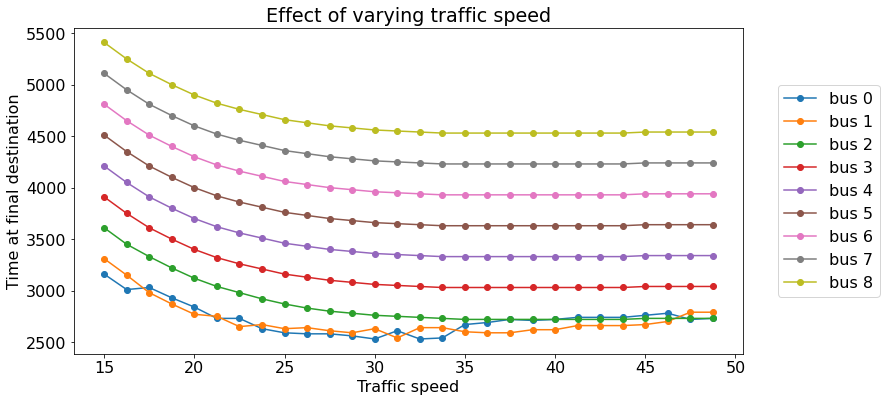

In [4]:
# Generate plots of the time at which each bus reaches the end of its route
plt.plot(traffic_speeds, ts_bus_end_times, marker="o", linestyle="-")
plt.xlabel("Traffic speed")
plt.ylabel("Time at final destination")
plt.title("Effect of varying traffic speed")
plt.legend(labels=["bus " + str(id) for id in ts_bus_ids], loc="center left", bbox_to_anchor=(1.04, 0.5));

In [5]:
# And also have a look at the arrival rates, which determine how many people wait at each stop (these are consistent as traffic speed changes due to the constant random seed)
print("Arrival rates at each bus stop:")
for ind, stop in enumerate(ts_bus_stop_arr_rates[0,:]):
    print(f"Bus stop {ind}:\t{stop:.4f}")

Arrival rates at each bus stop:
Bus stop 0:	0.0000
Bus stop 1:	0.0155
Bus stop 2:	0.0140
Bus stop 3:	0.0221
Bus stop 4:	0.0263
Bus stop 5:	0.0189
Bus stop 6:	0.0329
Bus stop 7:	0.0255
Bus stop 8:	0.0204
Bus stop 9:	0.0181
Bus stop 10:	0.0169
Bus stop 11:	0.0266
Bus stop 12:	0.0193
Bus stop 13:	0.0098
Bus stop 14:	0.0183
Bus stop 15:	0.0268
Bus stop 16:	0.0129
Bus stop 17:	0.0127
Bus stop 18:	0.0216
Bus stop 19:	0.0000


Most of the buses in this investigation have a relatively consistent relationship between final arrival time and traffic speed: at low speeds, they take longer and as speed increases they reach their destination faster, up until a point where increasing the speed has very little further effect.

The first buses to depart show more interesting variation with traffic speed, where at some (especially higher) traffic speeds the second bus overtakes the first after catching up with it at a stop.

Let's take a look at that happening at the fastest traffic speed:

In [6]:
# Define a function to handle multiple frames of the plot for animation
def drawframe(n, locations, points, axes):
    axes.set_title("Time = {}".format(n*10))
    points.set_xdata(locations[n])
    return points, axes

In [7]:
# Set up the plot at the first time-step
fig, ax = plt.subplots()
ts_bus_gps, = ax.plot(ts_gps_data[0,:], range(len(ts_gps_data[0,:])), "o")
plt.xlim((0, 40000))
plt.xlabel("Distance / m")
plt.ylabel("Bus ID")
ax.set_title("Traffic speed {}\nTime = 0".format(traffic_speeds[-1]))

# Add the animation data via fargs: gps traces, bus IDs and the axis
anim = animation.FuncAnimation(fig, drawframe, frames=ts_gps_data.shape[0], interval=50, fargs=(ts_gps_data, ts_bus_gps, ax), blit=False)
plt.close()  # Close this figure for now as we'll look at the animated version in the next cell

In [8]:
# Prepare the video for playing (note that you'll need to have ffmpeg installed for this to work; see the accompanying README.md file if not)
html = anim.to_html5_video()
HTML(html)

The traffic speed parameter gives us something nice to explore with Gaussian Processes.
For our first attempt at emulating an agent-based model, we want to obtain a handful of individual values from the emulator where the distribution of those values isn't too challenging/discontinuous.

The time at which each bus arrives at the final destination sets us up for an interesting emulation task - can we use the emulator to derive those values, when when it is more challenging to predict as some of the buses overtake each other at higher traffic speeds?

We'll return to the emulation task after exploring our other parameters.

### Arrival rates

We'll now try a more complex case - we'll vary how busy the bus service is by altering the maximum demand, which sets the arrival rate at each bus stop.

Demand at the individual stops was kept constant as the traffic speed varied in previous example, although it did differ between individual stops.

We will now look at two cases:
- Same demand at all stops
- Randomised demand levels (as before) but with a varying upper limit (to give quiet and busy routes)

In [9]:
%%capture
# Again, use capture to prevent plots that we don't need from showing

md_bus_ids = range(9)

max_demand = np.arange(0.25, 5.0, 0.25)

# First, hold arrival rate constant at all stops, based on max demand
mdc_bus_end_times = np.zeros((len(max_demand), len(md_bus_ids)))
mdc_bus_stop_arr_rates = np.zeros((len(max_demand), 20))

# Then simulate a second set of cases where arrival rate is derived from the maximum demand
mdv_bus_end_times = np.zeros((len(max_demand), len(md_bus_ids)))
mdv_bus_stop_arr_rates = np.zeros((len(max_demand), 20))

for ind, max_dem in enumerate(max_demand): 
    mdc_bus_end_times[ind,:], _, mdc_bus_stop_arr_rates[ind,:] = run_model_w_params(ArrivalRate=max_dem/60, bus_ids_out=md_bus_ids)  # constant arrival rate at all stops
    mdv_bus_end_times[ind,:], _, mdv_bus_stop_arr_rates[ind,:] = run_model_w_params(bus_ids_out=md_bus_ids, maxDemand=max_dem)       # variable arrival rate, with set upper limit

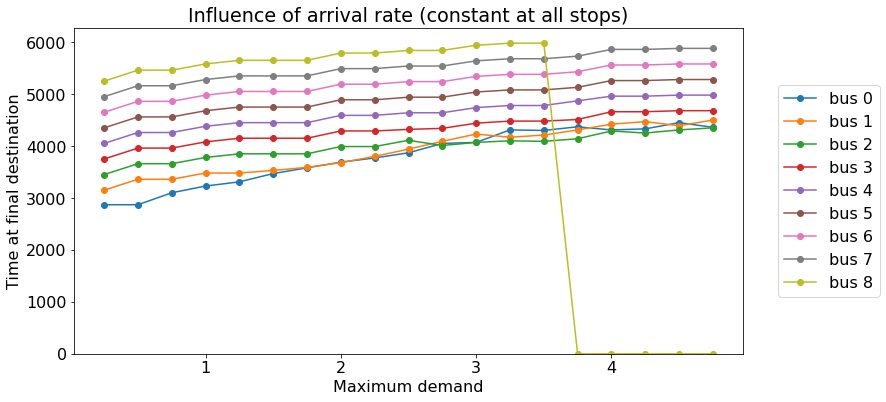

In [10]:
plt.plot(max_demand, mdc_bus_end_times, marker="o", linestyle="-")
plt.xlabel("Maximum demand")
plt.ylabel("Time at final destination")
plt.title("Influence of arrival rate (constant at all stops)")
plt.legend(labels=["bus " + str(id) for id in md_bus_ids], loc="center left", bbox_to_anchor=(1.04, 0.5))
plt.ylim(bottom=0);

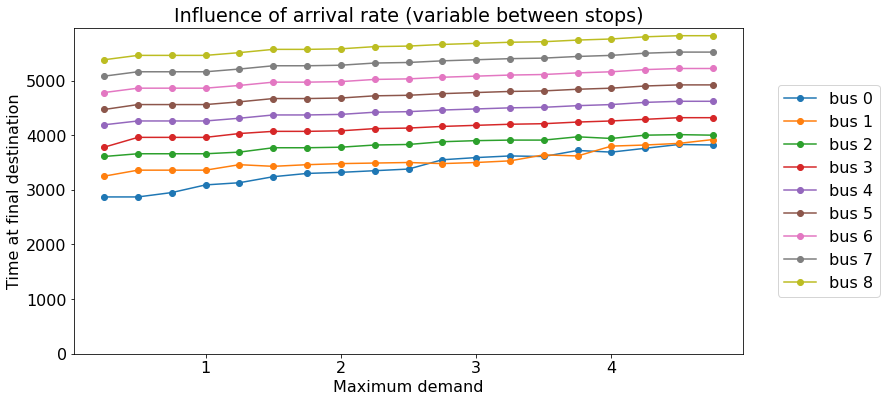

In [11]:
plt.plot(max_demand, mdv_bus_end_times, marker="o", linestyle="-")
plt.xlabel("Maximum demand")
plt.ylabel("Time at final destination")
plt.title("Influence of arrival rate (variable between stops)")
plt.legend(labels=["bus " + str(id) for id in md_bus_ids], loc="center left", bbox_to_anchor=(1.04, 0.5))
plt.ylim(bottom=0);

In [12]:
print("Arrival rates at each bus stop:")
print("\t\tConstant demand\t\tVariable demand")
print("\t\tLowest\tHighest\t\tLowest\tHighest")
for ind, (cstop_low, cstop_high, vstop_low, vstop_high) in enumerate(zip(mdc_bus_stop_arr_rates[0,:], mdc_bus_stop_arr_rates[-1,:], mdv_bus_stop_arr_rates[0,:], mdv_bus_stop_arr_rates[-1,:])):
    print(f"Bus stop {ind}:\t{cstop_low:.4f}\t{cstop_high:.4f}\t\t{vstop_low:.4f}\t{vstop_high:.4f}")

Arrival rates at each bus stop:
		Constant demand		Variable demand
		Lowest	Highest		Lowest	Highest
Bus stop 0:	0.0000	0.0000		0.0000	0.0000
Bus stop 1:	0.0042	0.0792		0.0071	0.0286
Bus stop 2:	0.0042	0.0792		0.0074	0.0244
Bus stop 3:	0.0042	0.0792		0.0060	0.0474
Bus stop 4:	0.0042	0.0792		0.0053	0.0593
Bus stop 5:	0.0042	0.0792		0.0066	0.0383
Bus stop 6:	0.0042	0.0792		0.0042	0.0778
Bus stop 7:	0.0042	0.0792		0.0055	0.0568
Bus stop 8:	0.0042	0.0792		0.0063	0.0424
Bus stop 9:	0.0042	0.0792		0.0067	0.0361
Bus stop 10:	0.0042	0.0792		0.0069	0.0326
Bus stop 11:	0.0042	0.0792		0.0053	0.0600
Bus stop 12:	0.0042	0.0792		0.0065	0.0394
Bus stop 13:	0.0042	0.0792		0.0081	0.0126
Bus stop 14:	0.0042	0.0792		0.0067	0.0365
Bus stop 15:	0.0042	0.0792		0.0053	0.0606
Bus stop 16:	0.0042	0.0792		0.0076	0.0213
Bus stop 17:	0.0042	0.0792		0.0076	0.0208
Bus stop 18:	0.0042	0.0792		0.0061	0.0460
Bus stop 19:	0.0000	0.0000		0.0000	0.0000


Again, we can see that there is generally a smooth trend of increasing time to final destination as demand is increased.

This time, the parameter values has more of an influence on whether buses bunch together and swap position, with this generally happening at higher levels of demand.

It is worth noting that one bus does not make it to the end of its route in the constant demand simulation; this is something to take care around later as the discontinuity may prove more challenging for the emulator.

## Introducing Gaussian process emulation

First of all, a quick introduction to GPs - how will they help us in this project?

Simulations, particularly agent-based models, often give highly detailed output yet can take a long time to run, especially in more complex models with large amounts of interaction between agents.
It is often necessary to run these models many times for studies such as parameter estimation, yet often the full output of the simulation is not required.

Emulation is highly useful in these cases: once fit, the trained model can be used for prediction of its outputs over and over again - far more quickly than the original model in many cases.

Useful resources for getting started include:
- **\<Fill in from notebook list later\>**


### Emulating bus arrival time with variable traffic speed

We'll try to emulate relatively simple outputs at first, sticking to only a few for each of our investigations.
In the first attempt at using the emulator, we'll attempt to emulate the time that buses 0, 4 and 9 (or the buses listed in `ts_busids`, if altered) arrive at their final destination for different values of traffic speed.

We'll provide fewer input points than we used in the investigations above, and see how the emulator performs.

We set up a Latin hypercube sampler over the selected traffic speed parameter space.
This will give us irregular yet generally evenly spread samples across the parameter space.

In [13]:
ts_busids = [0, 4, 9]  # select which buses we want to emulate

ts_lhd = mogp_emulator.LatinHypercubeDesign([(15.0, 50.0)])  # want to select values from traffic speed parameter space (between 15 and 50) with Latin hypercube sampling
ts_nsims = 15
np.random.seed(0)  # for reproducibility (change to np.random.seed() for different values each time)
ts_lhd_sample = ts_lhd.sample(ts_nsims)

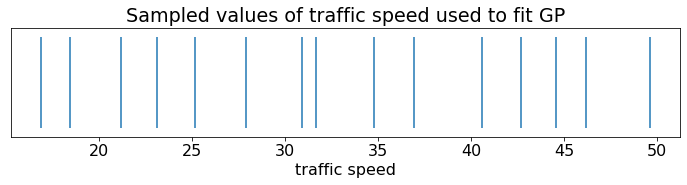

In [14]:
plt.figure(figsize=[12, 2])
plt.eventplot(ts_lhd_sample[:,0], lineoffsets=1)
plt.ylim((0.4,1.6))
plt.yticks([])
plt.xlabel("traffic speed")
plt.title("Sampled values of traffic speed used to fit GP");

In [15]:
%%capture
# Again, we'll capture the unneeded plots as we perform the simulations

ts_simulation_output = np.zeros((len(ts_busids), ts_nsims))

for ind, ts in enumerate(ts_lhd_sample):
    ts_simulation_output[:,ind], _, _ = run_model_w_params(TrafficSpeed=ts[0], bus_ids_out=ts_busids)

#### Fit the GP

As we want to emulate several outputs, we use the `MultiOutputGP` of the `mogp_emulator` package.

This class fits a separate emulator for each output.
The fitting function, `fit_GP_MAP` (Maximum A Posteriori), uses maximum likelihood estimation when no further priors are specified, as here.

In [16]:
ts_gp = mogp_emulator.MultiOutputGP(ts_lhd_sample, ts_simulation_output)
ts_gp = mogp_emulator.fit_GP_MAP(ts_gp)

Before examining the GP emulator's performance, let's take a look at its hyperparameters:

In [17]:
for ind, em in enumerate(ts_gp.emulators):
    print("Hyperparameters of the GP for bus {}:".format(ts_busids[ind]))
    print("Correlation length = {:.5}".format(np.sqrt(np.exp(-em.theta[0]))))
    print("Sigma = {:.5}".format(np.sqrt(np.exp(em.theta[1]))))
    print("Nugget = {:.5}\n".format(em.nugget))

Hyperparameters of the GP for bus 0:
Correlation length = 3.5039
Sigma = 1893.6
Nugget = 0.0

Hyperparameters of the GP for bus 4:
Correlation length = 1.0313e+04
Sigma = 1.2099e+05
Nugget = 1.4639e+04

Hyperparameters of the GP for bus 9:
Correlation length = 50.78
Sigma = 2.248e+04
Nugget = 505.37



The **correlation length** gives an indication of how much of a change in traffic speed is needed to introduce a significant change in the bus' arrival time at its final destination.
Comparing against the plot of arrival time against traffic speed earlier in this notebook indicates that these values are reasonable - we can see appreciable changes in arrival time for changes of 2-20 in traffic speed.
If we alter the number of simulations used as input, we can see that the quality of the fit will be affected.
For instance, try setting `ts_nsims=5`, and note the dramatic increase in the correlation length.

**Sigma** captures the overall variation in the arrival time.

The **nugget** term is a small addition to the diagonal of the covariance matrix, which aids with numerical stability.
We have used the default, "adaptive" option to set its value, where its small value is increased until it is possible to solve the system.
Its value can alternatively be optimised using the "fit" option, which we will investigate in the next notebook.

Notes on deriving these parameters from the $\theta$ vector are available in the [documentation](https://mogp-emulator.readthedocs.io/en/latest/intro/methoddetails.html?highlight=theta#hyperparameters) of the MOGP Emulator package.

#### Test out the GP

To test out how well the GP has performed, we compare a selection of emulated results against comparable simulated ones.

We will draw a set of traffic speed values from the same Latin hypercube sampler as before, and plot the simulated and emulated values at which the buses reach their final destination.

In [18]:
%%capture

# Select traffic speed values for validation
ts_validation_nsims = 50
np.random.seed(1)
ts_lhd_sample_validation = ts_lhd.sample(ts_validation_nsims)

# Predict outputs using the previously fitted GP emulator
ts_predicted = ts_gp.predict(ts_lhd_sample_validation, include_nugget=False)

# Also use the simulator to compute the exact results
ts_simulated = np.zeros((len(ts_busids), ts_validation_nsims))
for ind, ts in enumerate(ts_lhd_sample_validation):
    sim_out, _, _ = run_model_w_params(TrafficSpeed=ts[0], bus_ids_out=ts_busids)
    ts_simulated[:,ind] = np.array(sim_out)

In [19]:
# Some preparation for the plot:

# Set marker styles
plt_mk = { "train": "o",      # Used to train the GP
           "pred": "+",       # Predicted by the GP
           "sim": "x" }       # Same TS as "pred", full simulation

# Create legend labels
plt_mk_legend = [matplotlib.lines.Line2D([0], [0], marker=plt_mk["train"], color="w", label="Training",
                 markerfacecolor="k", markeredgecolor="k"), 
                 matplotlib.lines.Line2D([0], [0], marker=plt_mk["pred"], color="w", label="Predicted (GP)",
                 markerfacecolor="k", markeredgecolor="k"), 
                 matplotlib.lines.Line2D([0], [0], marker=plt_mk["sim"], color="w", label="Simulated",
                 markerfacecolor="k", markeredgecolor="k")]

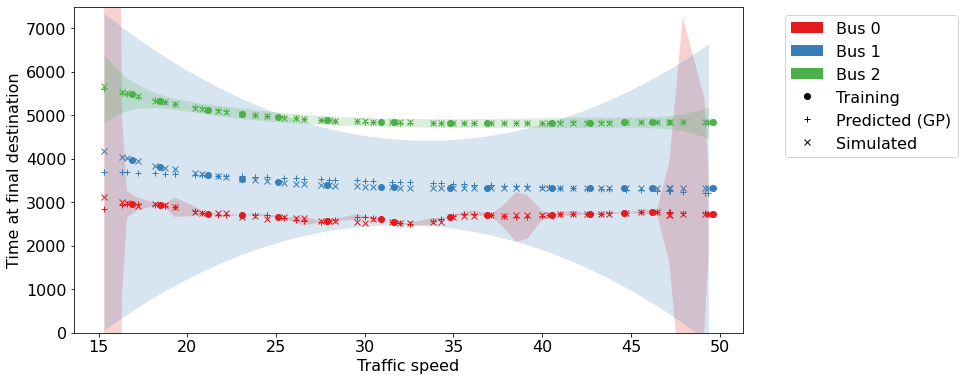

In [20]:
legend_entries = []

for ind, (a, p, u) in enumerate(zip(ts_simulated, ts_predicted.mean, ts_predicted.unc)):
    plt.plot(ts_lhd_sample_validation, a, marker=plt_mk["sim"], linestyle="", color=plt.cm.Set1(ind))
    plt.plot(ts_lhd_sample_validation, p, marker=plt_mk["pred"], linestyle="", color=plt.cm.Set1(ind))
    plt.plot(ts_lhd_sample, ts_simulation_output[ind,], marker=plt_mk["train"], linestyle="", color=plt.cm.Set1(ind))
    
    legend_entries.append(matplotlib.patches.Patch(facecolor=plt.cm.Set1(ind), edgecolor=None, label="Bus {}".format(ts_bus_ids[ind])))
    
    o = np.argsort(ts_lhd_sample_validation, axis=None)
    plt.fill_between(ts_lhd_sample_validation.flatten()[o], p[o]-u[o], p[o]+u[o],
                     color=plt.cm.Set1(ind), alpha=0.2, linewidth=0)
            
plt.xlabel("Traffic speed")
plt.ylabel("Time at final destination")
plt.legend(handles=legend_entries+plt_mk_legend, loc="upper left", bbox_to_anchor=(1.05, 1))
plt.ylim(0, 7500)  # Comment this line out to see limits of uncertainty for bus 0
plt.show()

Generally, the GP is doing a good job of simulating the final arrival time of each bus.

The uncertainty in the prediction of the arrival time of the first bus is particularly interesting, as the bounds are much wider than those of the other buses.
There were several occasions in when bus 0 was overtaken by buses 1 and 2 in our set of simulations earlier in this notebook, particularly around speeds of 40-45.
With that in mind, this increase in uncertainty does make sense.

In addition, some of the traffic speeds for which results were emulated can be larger/smaller than those in the dataset used to train the emulator.
High uncertainty bounds at the limits of traffic speed are often seen, even when larger numbers of simulations are used for training.

### Emulating bus arrival time with variable maximum demand

We will now repeat a similar analysis, but while changing the arrival rate.
Within each simulation, we will keep the arrival rate constant over all bus stops.

In [21]:
%%capture

# Select values for maximum demand (plotted below) and run simulations

md_busids = [0, 1, 2, 6]

md_nsims = 15
md_lhd = mogp_emulator.LatinHypercubeDesign([(0.25, 5.0)])
np.random.seed(2)
md_lhd_sample = md_lhd.sample(md_nsims)

md_simulation_output = np.zeros((len(md_busids), md_nsims))

for ind, max_dem in enumerate(md_lhd_sample):
    ArrivalRate = max_dem[0]/60
    sim_out, _, _ = run_model_w_params(ArrivalRate=ArrivalRate, bus_ids_out=md_busids)
    md_simulation_output[:,ind] = np.array(sim_out)

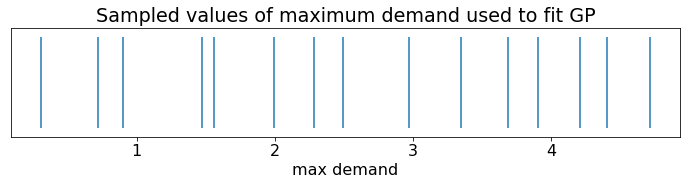

In [22]:
plt.figure(figsize=[12, 2])
plt.eventplot(md_lhd_sample[:,0], lineoffsets=1)
plt.ylim((0.4,1.6))
plt.yticks([])
plt.xlabel("max demand")
plt.title("Sampled values of maximum demand used to fit GP");

In [23]:
# Fit the Gaussian process emulator
md_gp = mogp_emulator.MultiOutputGP(md_lhd_sample, md_simulation_output)
md_gp = mogp_emulator.fit_GP_MAP(md_gp)

for ind, em in enumerate(md_gp.emulators):
    print("Hyperparameters of the GP for bus {}:".format(md_busids[ind]))
    print("Correlation length = {:.5}".format(np.sqrt(np.exp(-em.theta[0]))))
    print("Sigma = {:.5}".format(np.sqrt(np.exp(em.theta[1]))))
    print("Nugget = {:.5}\n".format(em.nugget))

Hyperparameters of the GP for bus 0:
Correlation length = 0.52337
Sigma = 2925.2
Nugget = 0.0

Hyperparameters of the GP for bus 1:
Correlation length = 0.54603
Sigma = 2646.0
Nugget = 0.0

Hyperparameters of the GP for bus 2:
Correlation length = 0.52549
Sigma = 2946.5
Nugget = 0.0

Hyperparameters of the GP for bus 6:
Correlation length = 0.53342
Sigma = 3659.7
Nugget = 0.0



In [24]:
%%capture

# For validation, select a further set of max demand values, sample from GP emulator and run simulations

md_nsims_validation = 50
np.random.seed(3)
md_lhd_sample_validation = md_lhd.sample(md_nsims_validation)

md_predicted = md_gp.predict(md_lhd_sample_validation)

md_simulated = np.zeros((len(md_busids), md_nsims_validation))
for ind, max_dem in enumerate(md_lhd_sample_validation):
    ArrivalRate = max_dem[0]/60
    sim_out, _, _ = run_model_w_params(ArrivalRate=ArrivalRate, bus_ids_out=md_busids)
    md_simulated[:,ind] = np.array(sim_out)

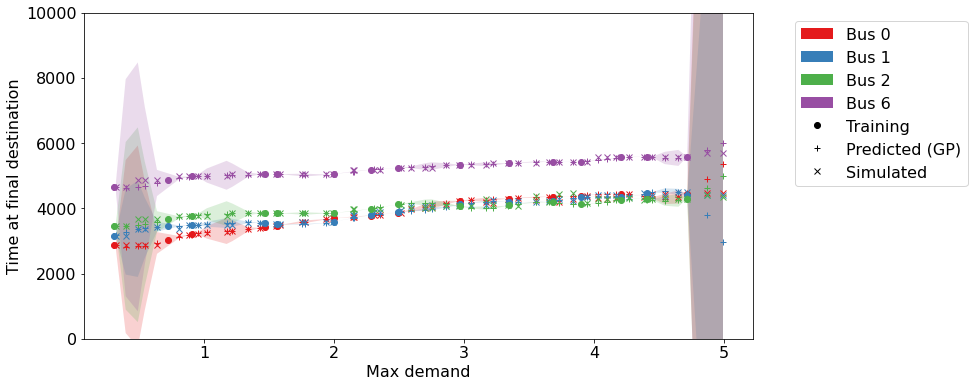

In [25]:
legend_entries = []

for ind, (a, p, u) in enumerate(zip(md_simulated, md_predicted.mean, md_predicted.unc)):
    plt.plot(md_lhd_sample_validation, a, marker=plt_mk["sim"], linestyle="", color=plt.cm.Set1(ind))
    plt.plot(md_lhd_sample_validation, p, marker=plt_mk["pred"], linestyle="", color=plt.cm.Set1(ind))
    plt.plot(md_lhd_sample, md_simulation_output[ind,], marker=plt_mk["train"], linestyle="", color=plt.cm.Set1(ind))
    
    legend_entries.append(matplotlib.patches.Patch(facecolor=plt.cm.Set1(ind), edgecolor=None, label="Bus {}".format(md_busids[ind])))
   
    o = np.argsort(md_lhd_sample_validation, axis=None)
    plt.fill_between(md_lhd_sample_validation.flatten()[o], p[o]-u[o], p[o]+u[o],
                     color=plt.cm.Set1(ind), alpha=0.2, linewidth=0)
        
plt.xlabel("Max demand")
plt.ylabel("Time at final destination")
plt.legend(handles=legend_entries+plt_mk_legend, loc="upper left", bbox_to_anchor=(1.05, 1))
plt.ylim((0, 10000))
plt.show()

Again, the GP emulator generally gives results that are very close to the simulated values, although this time with more regions of higher uncertainty.

Changing the number of points used to train the GP results in a poorer fit.
For example, trying with only five input points yields more noticeable differences in the mean output of the GP and the simulated output.

## Further model investigation: vary two parameters

Essentially we'll try the same procedure as before, but this time with two variable parameters.
We're looking out for how difficult it is for the GP to still provide a good estimate given that coverage of the parameter space is now going to be far harder.

As before, we run a set of simulations to train our GP on.
We'll take 12 samples from a Latin hypercube to pull out samples which cover the parameter space of traffic speeds of 15-50 and maximum demand at each bus stop of 0.25-5.
We then fit the GP and test its performance via comparison of a further set of simulations against corresponding samples from the GP.

In [26]:
%%capture

two_busids = [0, 1, 2, 6]

two_nsims = 30
two_lhd = mogp_emulator.LatinHypercubeDesign([(15.0, 50.0), (0.25, 5.0)])
np.random.seed(4)
two_lhd_sample = two_lhd.sample(two_nsims)

two_simulation_output = np.zeros((len(two_busids), two_nsims))

for ind, par in enumerate(two_lhd_sample):
    sim_out, _, _ = run_model_w_params(ArrivalRate=par[1]/60, TrafficSpeed=par[0], bus_ids_out=two_busids)
    two_simulation_output[:,ind] = np.array(sim_out)

In [27]:
two_gp = mogp_emulator.MultiOutputGP(two_lhd_sample, two_simulation_output)
two_gp = mogp_emulator.fit_GP_MAP(two_gp)

We now have two values for each of the hyperparameters: the first for the traffic speed, and the second for the maximum demand.
Should the number of simulations used to train the GP be much lower than ~20, the correlation lengths in particular become much higher that what you would expect from our studies of the model above, and the emulation is less successful.

In [28]:
for ind, em in enumerate(two_gp.emulators):
    print("Hyperparameters of the GP for bus {}:".format(md_busids[ind]))
    print("Correlation lengths = {:.5}, {:.5}".format(np.sqrt(np.exp(-em.theta[0])), np.sqrt(np.exp(-em.theta[1]))))
    print("Sigmas = {:.5}, {:.5}".format(np.sqrt(np.exp(em.theta[2])), np.sqrt(np.exp(em.theta[3]))))
    print("Nugget = {:.5}\n".format(em.nugget))

Hyperparameters of the GP for bus 0:
Correlation lengths = 7.38, 2.307
Sigmas = 2338.5, 0.36419
Nugget = 0.0

Hyperparameters of the GP for bus 1:
Correlation lengths = 3.0932, 4.3953
Sigmas = 1923.4, 2.6477
Nugget = 0.0

Hyperparameters of the GP for bus 2:
Correlation lengths = 3.4685, 3.0033
Sigmas = 2193.2, 0.51478
Nugget = 0.0

Hyperparameters of the GP for bus 6:
Correlation lengths = 9.1978, 1.4353
Sigmas = 2960.5, 2.3314
Nugget = 0.0



#### Validation: direct comparison

As previously, we will varry out a further set of simulations and compare their outputs against those from the GP emulator.

In [29]:
%%capture

two_nsims_validation = 30
np.random.seed(5)
two_lhd_sample_validation = two_lhd.sample(two_nsims_validation)

two_predicted = two_gp.predict(two_lhd_sample_validation)

two_simulated = np.zeros((len(two_busids), two_nsims_validation))
for ind, par in enumerate(two_lhd_sample_validation):
    sim_out, _, _ = run_model_w_params(ArrivalRate=par[1]/60, TrafficSpeed=par[0], bus_ids_out=two_busids)
    two_simulated[:,ind] = np.array(sim_out)

Visualising how well the GP performs is trickier now that we are in two dimensions.
First, we'll print out the predicted and simulated final arrival times for one of the buses for a quick manual comparison.

In [30]:
bus_index = 1
print("Bus %i\n-----" % two_busids[bus_index])

print("traffic speed\tmax demand\tprediction\t\tsimulation\tdifference")
for par, mean, unc, sim in zip(two_lhd_sample_validation, two_predicted.mean.T, two_predicted.unc.T, two_simulated.T):
    print("%.2f\t\t%.2f\t\t%.2f +/- %.2f\t%.2f\t\t% .2f" % (par[0], par[1], mean[bus_index], unc[bus_index], sim[bus_index], mean[bus_index]-sim[bus_index]))

Bus 1
-----
traffic speed	max demand	prediction		simulation	difference
28.91		1.99		3014.14 +/- 470.58	2980.00		 34.14
49.67		1.94		2694.08 +/- 171312.66	3100.00		-405.92
42.07		4.00		3278.34 +/- 8542.50	3420.00		-141.66
44.84		2.72		3423.10 +/- 3302.49	3310.00		 113.10
36.08		2.18		3091.93 +/- 1094.61	3050.00		 41.93
27.07		3.51		3430.40 +/- 26676.55	3470.00		-39.60
17.56		1.54		3090.09 +/- 163938.19	3030.00		 60.09
31.26		3.78		3480.73 +/- 2443.57	3410.00		 70.73
45.89		4.53		3349.46 +/- 44985.81	3550.00		-200.54
39.82		4.09		3252.57 +/- 34645.76	3470.00		-217.43
48.77		4.90		3409.06 +/- 8464.22	3410.00		-0.94
15.45		2.99		3779.48 +/- 1591.22	3850.00		-70.52
35.06		2.42		3113.26 +/- 12543.78	3330.00		-216.74
21.92		0.83		3177.05 +/- 19779.95	2570.00		 607.05
16.66		4.77		3962.13 +/- 19305.42	4140.00		-177.87
46.75		1.22		2723.28 +/- 4177.84	2710.00		 13.28
29.98		3.39		3406.95 +/- 143.06	3350.00		 56.95
39.08		0.59		2485.77 +/- 31019.58	2280.00		 205.77
37.37		1.73		3029.80 +/- 6642.

And we will also plot the same values on a 2D scatterplot.
The positions of the points show the location of the points in the traffic speed / maximum demand parameter space.
Note how the Latin hypercube design generally spaces them out well through the space, but there are still regions near the edges that are less well covered.

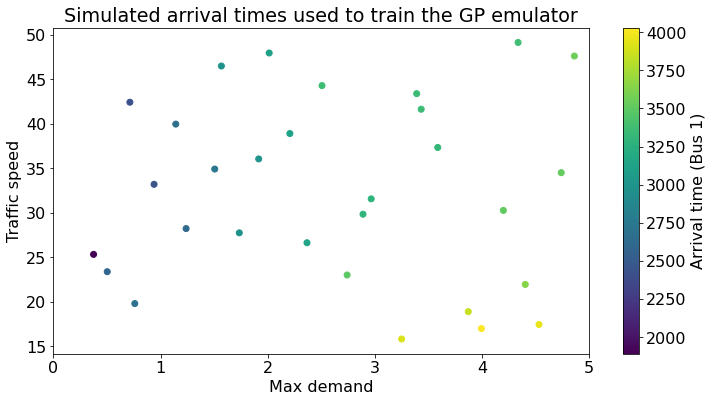

In [31]:
bus_index = 1

fig_train = plt.figure()
plt.scatter(two_lhd_sample[:,1], two_lhd_sample[:,0], c=two_simulation_output[bus_index,:], marker="o")

plt.xlabel("Max demand")
plt.ylabel("Traffic speed")
plt.title("Simulated arrival times used to train the GP emulator")
plt.colorbar(label="Arrival time (Bus {})".format(two_busids[bus_index]))
xlims = (0, 5)
plt.xlim(xlims)
plt.show()

#### Validation: constant traffic speed

To make visualisation easier, we will use a constant value of traffic speed for some further validation. 

In [32]:
%%capture
fixed_ts = 40
two_fix_lhd_sample_validation = two_lhd_sample_validation.copy()
two_fix_lhd_sample_validation[:,0] = fixed_ts

two_fix_predicted = two_gp.predict(two_fix_lhd_sample_validation)

two_fix_simulated = np.zeros((len(two_busids), two_nsims_validation))
for ind, par in enumerate(two_fix_lhd_sample_validation):
    sim_out, _, _ = run_model_w_params(ArrivalRate=par[1]/60, TrafficSpeed=fixed_ts, bus_ids_out=two_busids)
    two_fix_simulated[:,ind] = np.array(sim_out)

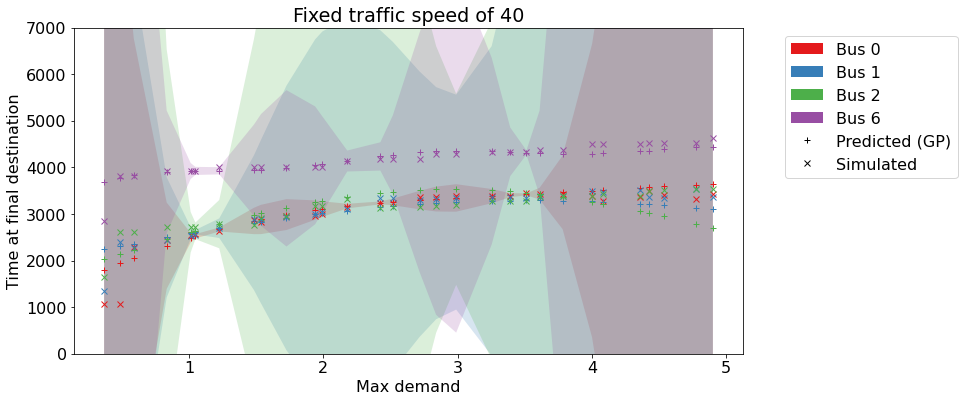

In [33]:
legend_entries = []

for ind, (a, p, u) in enumerate(zip(two_fix_simulated, two_fix_predicted.mean, two_fix_predicted.unc)):
    plt.plot(two_fix_lhd_sample_validation[:,1], a, marker=plt_mk["sim"], linestyle="", color=plt.cm.Set1(ind))
    plt.plot(two_fix_lhd_sample_validation[:,1], p, marker=plt_mk["pred"], linestyle="", color=plt.cm.Set1(ind))
    # Note that training data hasn't been included here as it was obtained at different values of traffic speed    
    
    legend_entries.append(matplotlib.patches.Patch(facecolor=plt.cm.Set1(ind), edgecolor=None, label="Bus {}".format(two_busids[ind])))
        
    o = np.argsort(two_fix_lhd_sample_validation[:,1], axis=None)
    plt.fill_between(two_fix_lhd_sample_validation[o,1], p[o]-u[o], p[o]+u[o],
                     color=plt.cm.Set1(ind), alpha=0.2, linewidth=0)
        
plt.xlabel("Max demand")
plt.ylabel("Time at final destination")
plt.title("Fixed traffic speed of {}".format(fixed_ts))
plt.legend(handles=legend_entries+plt_mk_legend[1:], loc="upper left", bbox_to_anchor=(1.05, 1))
plt.ylim((0, 7000))
plt.show()

Note that the parameter combinations used to fit the GP may not have had traffic speed set to the fixed value above.

For instance, the traffic speed used in the plot above is near the following points used to train the GP:

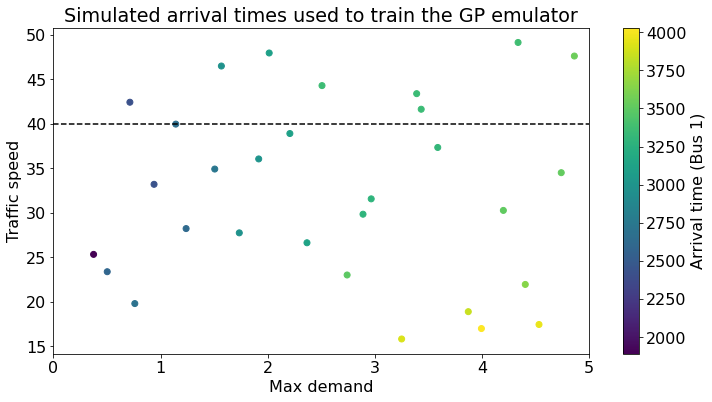

In [34]:
fig_train.gca().plot(xlims, [fixed_ts, fixed_ts], color="k", linestyle="--")
fig_train

### Testing the impact of additional points to train the GP

It is clear from the plots above that regions of parameter space without adequate coverage when fitting the GP result in high uncertainties when making predictions using the GP.
Interestingly, the mean predictions from the GP are very close to the outputs of the corresponding simulations despite this issue.

We will now generate several GP emulators, trained on increasing numbers of input points.

In [35]:
%%capture
n_consimulations = [8, 16, 32, 64]

twocon_gps = []
np.random.seed(6)

# Fit a GP with each number of input simulations
for n in n_consimulations:
    twocon_lhd_sample = two_lhd.sample(n)    # Use the LHD from earlier, with limits of 15-50 for traffic speed and 0.25-5 for arrival rate
    twocon_simulation_output = np.zeros((len(two_busids), n))

    for ind, par in enumerate(twocon_lhd_sample):
        sim_out, _, _ = run_model_w_params(ArrivalRate=par[1]/60, TrafficSpeed=par[0], bus_ids_out=two_busids)
        twocon_simulation_output[:,ind] = np.array(sim_out)
        
    twocon_gp = mogp_emulator.MultiOutputGP(twocon_lhd_sample, twocon_simulation_output)
    twocon_gp = mogp_emulator.fit_GP_MAP(twocon_gp)
    twocon_gps.append(twocon_gp)

In [36]:
# Generate the parameter combinations at which we want to test out the GP
twocon_nsims_validation = 10
np.random.seed(7)
twocon_lhd_sample_validation = two_lhd.sample(twocon_nsims_validation)

# Use each GP to predict the arrival times given these parameters
twocon_predicted = []
for gp in twocon_gps:
    twocon_predicted.append(gp.predict(twocon_lhd_sample_validation))

In [37]:
%%capture
# Perform the full simulation at each of these parameter combinations
twocon_simulated = np.zeros((len(two_busids), twocon_nsims_validation))
twocon_simulated_gps = []
for ind, par in enumerate(twocon_lhd_sample_validation):
    sim_out, gps, _ = run_model_w_params(ArrivalRate=par[1]/60, TrafficSpeed=par[0], bus_ids_out=two_busids)
    twocon_simulated[:,ind] = np.array(sim_out)
    twocon_simulated_gps.append(gps)

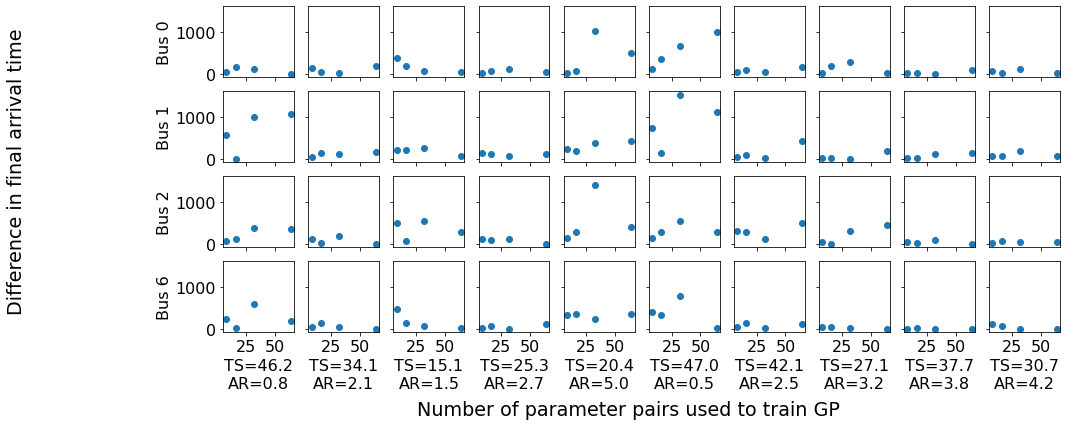

In [38]:
fig, axes = plt.subplots(*twocon_predicted[0].mean.shape, sharex=True, sharey=True)
fig.set_figwidth(15)

diffs = np.zeros((len(n_consimulations), twocon_predicted[0].mean.shape[0], twocon_predicted[0].mean.shape[1]))
for p_ind, preds in enumerate(twocon_predicted):
    diffs[p_ind,:, :] = np.abs(preds.mean - twocon_simulated)
    
for bus_ind in range(twocon_predicted[0].mean.shape[0]):
    for par_ind in range(twocon_predicted[0].mean.shape[1]):
        axes[bus_ind, par_ind].scatter(n_consimulations, diffs[:, bus_ind, par_ind], marker="o")
        
        if bus_ind == twocon_predicted[0].mean.shape[0] - 1:
            axes[bus_ind, par_ind].set(xlabel=f"TS={twocon_lhd_sample_validation[par_ind,0]:.1f}" + "\n" + f"AR={twocon_lhd_sample_validation[par_ind,1]:.1f}")
    
        if par_ind == 0:
            axes[bus_ind, par_ind].set(ylabel="Bus " + str(two_busids[bus_ind]))

        
fig.supxlabel("Number of parameter pairs used to train GP", y=-0.075);
fig.supylabel("Difference in final arrival time", x=-0.075);

The plot above is complex but informative:
    - Each column shows the differences in the prediction of the GP emulator and the simulator at a particular pair of traffic speed and arrival rate values.
    - Each row shows those differences for a given bus.
    - The data points within each plot show how the difference in output is affected by the number of points used to train the GP.
    
We would generally expect more training points to result in better quality of emulation, but here we also have to consider the distribution of the training points across the parameter space.

#### GP emulator evaluation: where does it perform badly?

Let's now pick out certain parameter combinations from the plot above where the GP emulator is not able to perform well.

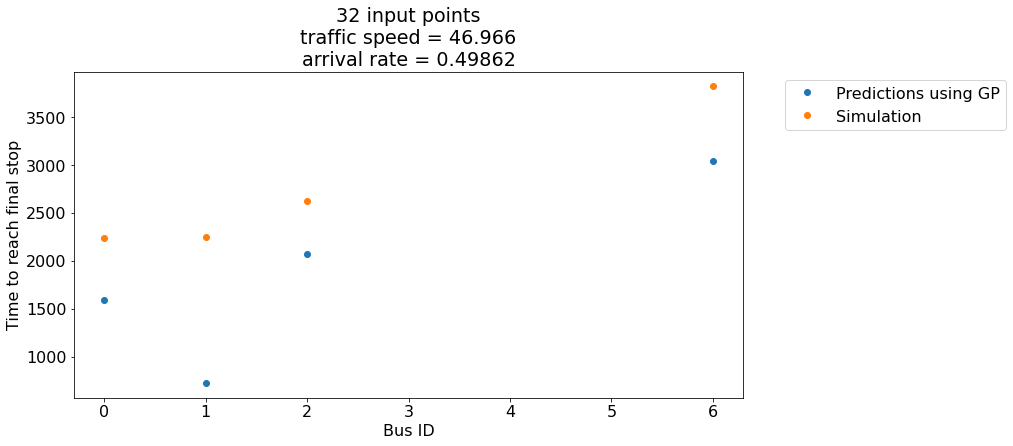

In [39]:
par_index = 5       # column ID, from 0 at the left of the plot above
bus_ind_plot = 2    # row ID, from 0 at the top of the plot above
n_train_ind = 2     # point ID, from 0 at the left of each subplot within the plot above

plt.plot(two_busids, twocon_predicted[n_train_ind].mean[:,par_index], "o", label="Predictions using GP")
plt.plot(two_busids, twocon_simulated[:,par_index], "o", label="Simulation")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
plt.xlabel("Bus ID")
plt.ylabel("Time to reach final stop")
plt.title("{} input points\ntraffic speed = {:.5}\narrival rate = {:.5}".format(n_consimulations[n_train_ind], twocon_lhd_sample_validation[par_index, 0], twocon_lhd_sample_validation[par_index, 1]))
plt.show()

Some of the subplots above clearly indicate that the GP emulator makes poor predictions.
In the plot immediately above, we have pulled out one of the more obvious cases where bus 1 was predicted to arrive over 1000 time-steps earlier than it actually did.
We can examine one of them more clearly by plotting the locations (GPS) of the buses.

In [40]:
# Set up plot at first time-step
gps_fig, gps_ax = plt.subplots()
twocon_bus_gps, = gps_ax.plot(twocon_simulated_gps[par_index][0,:], range(len(twocon_simulated_gps[par_index][0,:])), "o")
plt.xlim((0, 40000))
plt.xlabel("Distance / m")
plt.ylabel("Bus ID")
ax.set_title("Time = 0")

# Add the animation data 
gps_anim = animation.FuncAnimation(gps_fig, drawframe, frames=twocon_simulated_gps[par_index].shape[0], interval=50, fargs=(twocon_simulated_gps[par_index], twocon_bus_gps, gps_ax), blit=False)
plt.close()

In [41]:
gps_html = gps_anim.to_html5_video()
HTML(gps_html)

Checking on the simulated data above shows that while bus 1 does overtake bus 0, it does not move substantially past it.
To better understand why the GP emulator predicts such a shorter trip duration, we should also examine some of the training data: was clearer overtaking a common theme there?
In addition, we can note that the values of traffic speed and arrival rate associated with this prediction were close to the limits of those tested, so it may be that coverage of parameter space was again an issue.

We have also so far only considered the mean prediction from the GP.
Below, we plot the uncertainties associated with the arrival time predictions from each of the emulators.

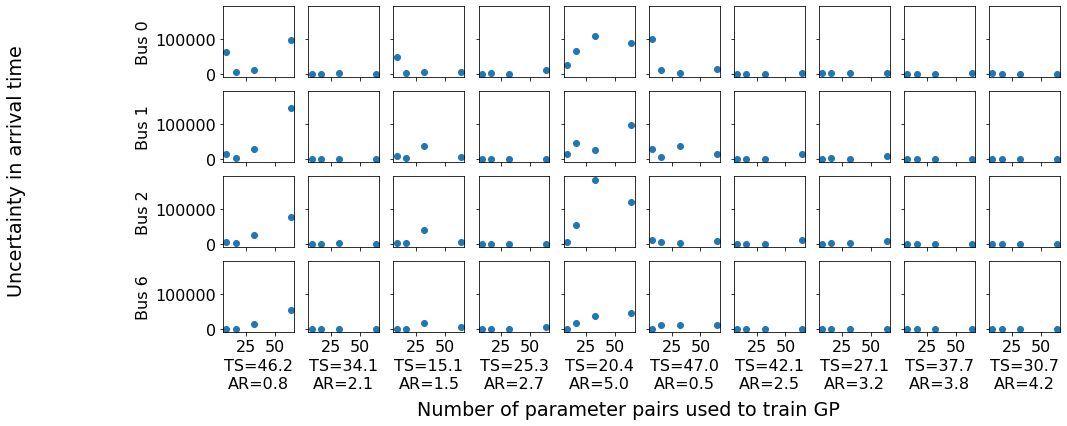

In [42]:
fig, axes = plt.subplots(*twocon_predicted[0].mean.shape, sharex=True, sharey=True)
fig.set_figwidth(15)

diffs = np.zeros((len(n_consimulations), twocon_predicted[0].unc.shape[0], twocon_predicted[0].unc.shape[1]))
for p_ind, preds in enumerate(twocon_predicted):
    diffs[p_ind,:, :] = preds.unc
    
for bus_ind in range(twocon_predicted[0].unc.shape[0]):
    for par_ind in range(twocon_predicted[0].unc.shape[1]):
        axes[bus_ind, par_ind].scatter(n_consimulations, diffs[:, bus_ind, par_ind], marker="o")
        
        if bus_ind == twocon_predicted[0].mean.shape[0] - 1:
            axes[bus_ind, par_ind].set(xlabel=f"TS={twocon_lhd_sample_validation[par_ind,0]:.1f}" + "\n" + f"AR={twocon_lhd_sample_validation[par_ind,1]:.1f}")
    
        if par_ind == 0:
            axes[bus_ind, par_ind].set(ylabel="Bus " + str(two_busids[bus_ind]))

        
fig.supxlabel("Number of parameter pairs used to train GP", y=-0.075);
fig.supylabel("Uncertainty in arrival time", x=-0.075);

# plt.ylim((0, 3000));    # reduce the ylimits to see the range of uncertainty at the lower levels

The uncertainty plots align with what we already saw from the differences in arrival time: where we could see the emulator performing poorly above, here it had exceedingly high uncertainty associated with its predictions.
The highest values of uncertainty are generally seen in specific combinations of traffic speed and arrival rate, regardless of the number of points provided as input to the simulator.
These particular combinations are at the outer limits of the parameter range: the fifth plot from the left here was rather low traffic speed and the highest possible arrival rate, and the first and sixth have very low arrival rates and high traffic speeds.

Coverage of the parameter space is clearly something we should consider very carefully as we move on to the next stage of this study, which expands the model by introducing some stochasticity.